# Machine Learning Modeling


In this notebook, we build a logistic regression classifier to predict the likelihood of flight cancellations given flight information, weather data and some historical performances of airlines.

## Loading modules

In [1]:
import pandas as pd
import numpy as np
% pylab inline
import operator
import re
from collections import OrderedDict
import seaborn as sns
import pickle
import os.path
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Setting some plot colors and parameters

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
# Adapted from http://spartanideas.msu.edu/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
cmap_set1 = ListedColormap(['#4daf4a', '#377eb8', '#e41a1c' ])

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
sns.set_style('ticks')

## Setting data frame display

In [3]:
pd.set_option('display.max_columns', None)

## Loading the data

We have acquired and merged the data in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/DataAcquisitionMerging/data_acquisition_merging.ipynb). The merged data was also cleaned by fixing the missing values in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/DataCleaning/data_cleaning.ipynb). A lot of features from the cleaned data was removed (or some features were selected) in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/EDA/ExploratoryDataAnalysis_v1.ipynb). The resultant csv file is loaded below:

In [4]:
df = pd.read_csv("../Data/ExploredDataCleaned/FlightHistory_Weather_Jan2015-Dec2016_Top20Airports_Window60mins_ExploredCleaned.csv")

In [5]:
df.shape

(2857139, 69)

In [6]:
df.head()

,Unnamed: 0,Month,DayofMonth,DayOfWeek,Carrier,Origin,Dest,Cancelled,Distance,Nflights_10,DepDelayMedian_10,DepDelayMax_10,ArrDelayMedian_10,ArrDelayMax_10,TaxiOutMedian_10,TaxiInMedian_10,Ncan_10,Ndiv_10,Nflights_20,DepDelayMedian_20,DepDelayMax_20,ArrDelayMedian_20,ArrDelayMax_20,TaxiOutMedian_20,TaxiInMedian_20,Ncan_20,Ndiv_20,Nflights_30,DepDelayMedian_30,DepDelayMax_30,ArrDelayMedian_30,ArrDelayMax_30,TaxiOutMedian_30,TaxiInMedian_30,Ncan_30,Ndiv_30,CRSDepHr,CRSArrHr,Temperature_Origin,DewPoint_Origin,Humidity_Origin,WindSpeed_Origin,WindDirection_Origin,Visibility_Origin,Pressure_Origin,Condition_Origin,Temperature_Dest,DewPoint_Dest,Humidity_Dest,WindSpeed_Dest,WindDirection_Dest,Visibility_Dest,Pressure_Dest,Condition_Dest,Month_Dest,DayOfMonth_Dest,DayOfWeek_Dest,TempFlight_30,TempFlight_20,TempFlight_10,AllCanceled_30,AllDiverted_30,AllCanceled_20,AllDiverted_20,AllCanDiv_20,AllCanDiv_30,AllCanceled_10,AllDiverted_10,AllCanDiv_10
0,0,1,1,4,AA,PHX,DFW,1.0,868.0,10,-2.0,0.0,-2.5,17.0,13.0,4.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,2,5,37.0,30.0,76.0,3.5,320.0,10.0,30.04,Scattered Clouds,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,4,NK,PHX,DFW,0.0,868.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,37.0,30.9,79.0,4.6,300.0,10.0,30.03,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
2,2,1,1,4,DL,DEN,ATL,0.0,1199.0,10,3.5,48.0,-7.5,52.0,15.0,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,0,5,7.0,-8.0,51.0,15.0,170.0,10.0,30.22,Clear,33.1,26.1,75.0,3.5,310.0,10.0,30.32,Partly Cloudy,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1,1,4,NK,LAS,MSP,0.0,1299.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5,34.0,17.1,50.0,9.2,190.0,10.0,29.99,Mostly Cloudy,16.0,10.0,77.0,8.1,240.0,10.0,29.90,Overcast,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
4,4,1,1,4,NK,LAS,DFW,0.0,1055.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,32.0,17.1,54.0,10.4,190.0,10.0,30.00,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0


In [7]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [8]:
df.head()

,Month,DayofMonth,DayOfWeek,Carrier,Origin,Dest,Cancelled,Distance,Nflights_10,DepDelayMedian_10,DepDelayMax_10,ArrDelayMedian_10,ArrDelayMax_10,TaxiOutMedian_10,TaxiInMedian_10,Ncan_10,Ndiv_10,Nflights_20,DepDelayMedian_20,DepDelayMax_20,ArrDelayMedian_20,ArrDelayMax_20,TaxiOutMedian_20,TaxiInMedian_20,Ncan_20,Ndiv_20,Nflights_30,DepDelayMedian_30,DepDelayMax_30,ArrDelayMedian_30,ArrDelayMax_30,TaxiOutMedian_30,TaxiInMedian_30,Ncan_30,Ndiv_30,CRSDepHr,CRSArrHr,Temperature_Origin,DewPoint_Origin,Humidity_Origin,WindSpeed_Origin,WindDirection_Origin,Visibility_Origin,Pressure_Origin,Condition_Origin,Temperature_Dest,DewPoint_Dest,Humidity_Dest,WindSpeed_Dest,WindDirection_Dest,Visibility_Dest,Pressure_Dest,Condition_Dest,Month_Dest,DayOfMonth_Dest,DayOfWeek_Dest,TempFlight_30,TempFlight_20,TempFlight_10,AllCanceled_30,AllDiverted_30,AllCanceled_20,AllDiverted_20,AllCanDiv_20,AllCanDiv_30,AllCanceled_10,AllDiverted_10,AllCanDiv_10
0,1,1,4,AA,PHX,DFW,1.0,868.0,10,-2.0,0.0,-2.5,17.0,13.0,4.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,2,5,37.0,30.0,76.0,3.5,320.0,10.0,30.04,Scattered Clouds,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,4,NK,PHX,DFW,0.0,868.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,37.0,30.9,79.0,4.6,300.0,10.0,30.03,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
2,1,1,4,DL,DEN,ATL,0.0,1199.0,10,3.5,48.0,-7.5,52.0,15.0,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,0,5,7.0,-8.0,51.0,15.0,170.0,10.0,30.22,Clear,33.1,26.1,75.0,3.5,310.0,10.0,30.32,Partly Cloudy,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,4,NK,LAS,MSP,0.0,1299.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5,34.0,17.1,50.0,9.2,190.0,10.0,29.99,Mostly Cloudy,16.0,10.0,77.0,8.1,240.0,10.0,29.90,Overcast,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
4,1,1,4,NK,LAS,DFW,0.0,1055.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,32.0,17.1,54.0,10.4,190.0,10.0,30.00,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(2857139, 68)

There are some variables with numerical values and some variables with categories. For numerical variables, we do not have to worry about labelling. However, we will need to perform label encoding for the categorical variables. There are also some variables that are already in binary form, so that also does not need any labeling. Let's first identify all the numerical, categorical and binary variables.

In [10]:
numvar = ["Distance", "Nflights_10", "DepDelayMedian_10", "DepDelayMax_10", "ArrDelayMedian_10",
          "ArrDelayMax_10", "TaxiOutMedian_10", "TaxiInMedian_10", "Ncan_10", "Ndiv_10", "Nflights_20",
          "DepDelayMedian_20", "DepDelayMax_20", "ArrDelayMedian_20", "ArrDelayMax_20", "TaxiOutMedian_20",
          "TaxiInMedian_20", "Ncan_20", "Ndiv_20", "Nflights_30", "DepDelayMedian_30", "DepDelayMax_30", 
          "ArrDelayMedian_30", "ArrDelayMax_30", "TaxiOutMedian_30", "TaxiInMedian_30", "Ncan_30", 
          "Ndiv_30", "Temperature_Origin", "DewPoint_Origin", "Humidity_Origin", "WindSpeed_Origin", 
          "WindDirection_Origin", "Visibility_Origin", "Pressure_Origin", "Temperature_Dest", "DewPoint_Dest",
          "Humidity_Dest", "WindSpeed_Dest", "WindDirection_Dest", "Visibility_Dest", "Pressure_Dest"]
catvar = ["Month", "DayofMonth", "DayOfWeek", "Carrier", "Origin", "Dest", "CRSDepHr", "CRSArrHr", 
          "Condition_Origin", "Condition_Dest", "Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest"]
binvar = ["TempFlight_30", "TempFlight_20", "TempFlight_10", "AllCanceled_30", "AllDiverted_30", 
          "AllCanceled_20", "AllDiverted_20", "AllCanDiv_20", "AllCanDiv_30", "AllCanceled_10", 
          "AllDiverted_10", "AllCanDiv_10"]

## Converting string values to numerical values in all categorical columns

In [11]:
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()
tmp = df[catvar].apply(lbl_enc.fit_transform) 

In [12]:
df.drop(catvar, axis=1, inplace=True)
df = pd.concat([df, tmp], axis=1)

In [13]:
df.shape

(2857139, 68)

In [14]:
colnames = list(df.columns[1:])

## Creating feature matrix and target vector

In [15]:
X = df.drop(["Cancelled"], axis=1).values
y = df.Cancelled.astype(int).values

In [16]:
X.shape

(2857139, 67)

## Considering only 10% of the data for speed

For speeding up the process, we only consider 10% of the data for building the model. Once we have some rough idea about good process and hyper parameters, we will consider full dataset. 

In [73]:
from sklearn.model_selection import StratifiedShuffleSplit
# Since we have highly imbalanced data, we use stratified splitting
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=10)
for keep_index, leave_index in sss.split(X, y):
    X_keep, X_leave = X[keep_index], X[leave_index]
    y_keep, y_leave = y[keep_index], y[leave_index]

## Splitting the data into train (50%) and test (50%) sets

In [74]:
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=20)
for train_index, test_index in sss1.split(X_keep, y_keep):
    X_train, X_test = X_keep[train_index], X_keep[test_index]
    y_train, y_test = y_keep[train_index], y_keep[test_index]

In [75]:
X_train.shape

(142856, 67)

In [76]:
X_test.shape

(142857, 67)

Just to make sure that stratified shuffle split led to train and test with same fraction of positive class, lets calculate the fractions.

In [77]:
sum(df.iloc[train_index].Cancelled == 1)/len(train_index)

0.031654253234025875

In [78]:
sum(df.iloc[test_index].Cancelled == 1)/len(test_index)

0.031276031276031277

They are indeed quite similar.

## Using undersampling on training data, no class_weight: Maximize PR AUC

In [79]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as pl
from imblearn.under_sampling import RandomUnderSampler
# Steps for pipeline
steps = [("rus", RandomUnderSampler(random_state=30)),
         ("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", LogisticRegression(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(model__C = [1e-8, 1e-7, 1e-6],
                  model__penalty = ['l1', 'l2']
                  #model__class_weight = ['balanced', {0:0.05, 1:0.95}, {0:0.1, 1:0.9}]
                  )
# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
LRrusPR = GridSearchCV(pipe, param_grid = param_grid, 
                           verbose = 3,
                           cv = cv,
                          n_jobs=-1,
                          scoring='average_precision',
                          iid=False)
# Training using CV
LRrusPR.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] model__C=1e-08, model__penalty=l1 ...............................
[CV] model__C=1e-08, model__penalty=l1 ...............................
[CV] model__C=1e-08, model__penalty=l1 ...............................
[CV] model__C=1e-08, model__penalty=l1 ...............................
[CV] model__C=1e-08, model__penalty=l1 ...............................
[CV]  model__C=1e-08, model__penalty=l1, score=0.505740, total=   0.4s
[CV] model__C=1e-08, model__penalty=l2 ...............................
[CV]  model__C=1e-08, model__penalty=l1, score=0.505740, total=   0.4s
[CV] model__C=1e-08, model__penalty=l2 ...............................
[CV] model__C=1e-08, model__penalty=l2 ...............................
[CV]  model__C=1e-08, model__penalty=l1, score=0.505740, total=   0.5s
[CV] model__C=1e-08, model__penalty=l2 ...............................
[CV]  model__C=1e-08, model__penalty=l1, score=0.505740, total=   0.6s
[CV] model__C=1e-

[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:    4.4s remaining:    0.7s


[CV]  model__C=1e-06, model__penalty=l2, score=0.098743, total=   0.5s
[CV]  model__C=1e-06, model__penalty=l2, score=0.075352, total=   0.5s
[CV]  model__C=1e-06, model__penalty=l2, score=0.086316, total=   0.4s
CPU times: user 3.41 s, sys: 278 ms, total: 3.69 s
Wall time: 5.24 s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


In [80]:
LRrusPR.best_params_

{'model__C': 1e-08, 'model__penalty': 'l1'}

#####################
Test data
#####################
F1:  0.0
Cohen Kappa:  0.0
Brier:  0.011487011487
LogLoss:  0.69314718056
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    141216
          1       0.00      0.00      0.00      1641

avg / total       0.98      0.99      0.98    142857



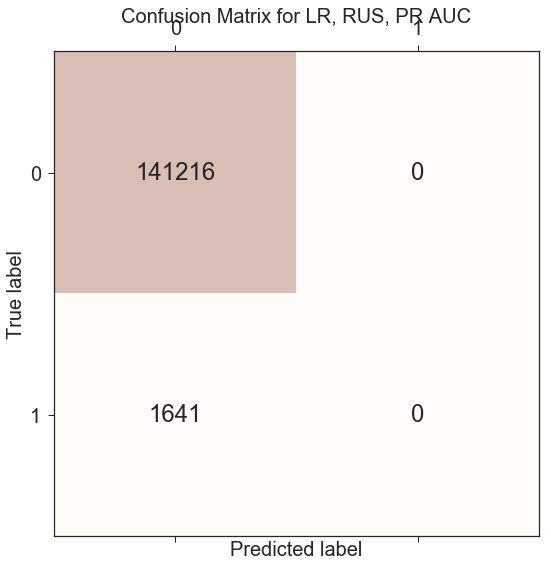

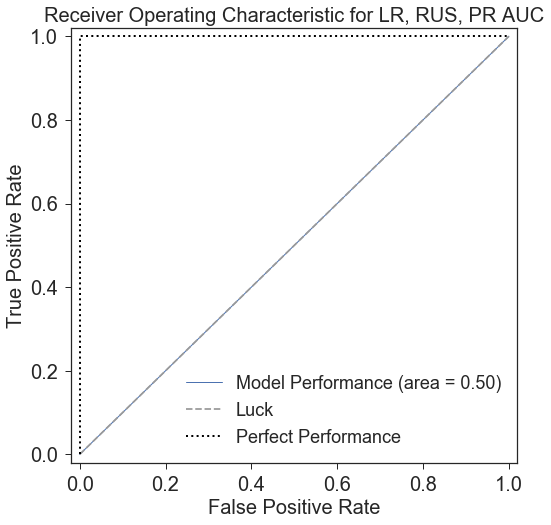

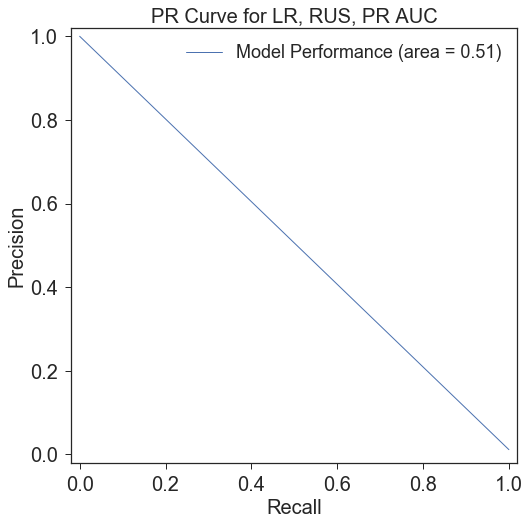

In [81]:
result(LRrusPR, X_train, y_train, X_test, y_test, train_result=False, clf_name="LR, RUS, PR AUC")

## Using undersampling on training data, no scaling, no class_weight: Maximize ROC AUC

In [82]:
%%time
# Steps for pipeline
steps = [("rus", RandomUnderSampler(random_state=30)),
         ("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", LogisticRegression(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(model__C = [1, 2, 3],
                  model__penalty = ['l1', 'l2']
                  #model__class_weight = ['balanced', {0:0.05, 1:0.95}, {0:0.1, 1:0.9}]
                  )
# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
LRrusROC = GridSearchCV(pipe, param_grid = param_grid, 
                           verbose = 3,
                           cv = cv,
                          n_jobs=-1,
                          scoring='roc_auc',
                          iid=False)
# Training using CV
LRrusROC.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] model__C=1, model__penalty=l1 ...................................
[CV] model__C=1, model__penalty=l1 ...................................
[CV] model__C=1, model__penalty=l1 ...................................
[CV] model__C=1, model__penalty=l1 ...................................
[CV] model__C=1, model__penalty=l1 ...................................
[CV] model__C=1, model__penalty=l2 ...................................
[CV] model__C=1, model__penalty=l2 ...................................
[CV] .... model__C=1, model__penalty=l1, score=0.790282, total=   0.6s
[CV] model__C=1, model__penalty=l2 ...................................
[CV] .... model__C=1, model__penalty=l1, score=0.771061, total=   0.5s
[CV] model__C=1, model__penalty=l2 ...................................
[CV] model__C=1, model__penalty=l2 ...................................
[CV] .... model__C=1, model__penalty=l1, score=0.769889, total=   0.8s
[CV] .... model__

[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:    5.5s remaining:    0.9s


[CV] .... model__C=3, model__penalty=l2, score=0.770601, total=   0.6s
[CV] .... model__C=3, model__penalty=l1, score=0.770615, total=   2.0s
[CV] .... model__C=3, model__penalty=l2, score=0.773993, total=   0.6s
[CV] .... model__C=3, model__penalty=l1, score=0.773635, total=   2.5s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.1s finished


CPU times: user 3.94 s, sys: 173 ms, total: 4.11 s
Wall time: 7 s


In [83]:
LRrusROC.best_params_

{'model__C': 2, 'model__penalty': 'l1'}

#####################
Test data
#####################
F1:  0.0606754755985
Cohen Kappa:  0.0396231981382
Brier:  0.235375235375
LogLoss:  0.558041251922
             precision    recall  f1-score   support

          0       0.99      0.77      0.87    141216
          1       0.03      0.66      0.06      1641

avg / total       0.98      0.76      0.86    142857



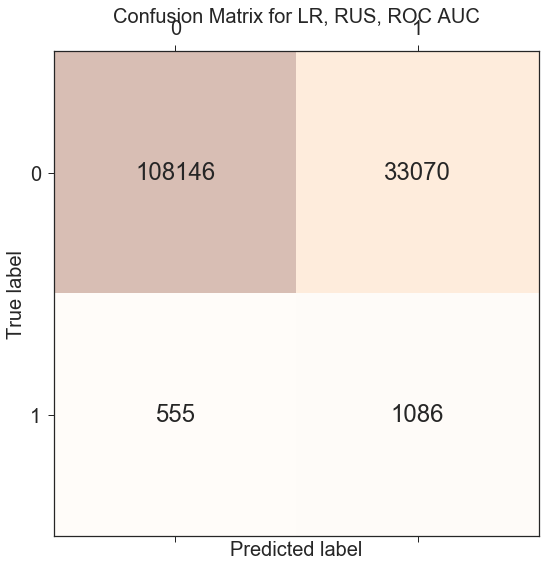

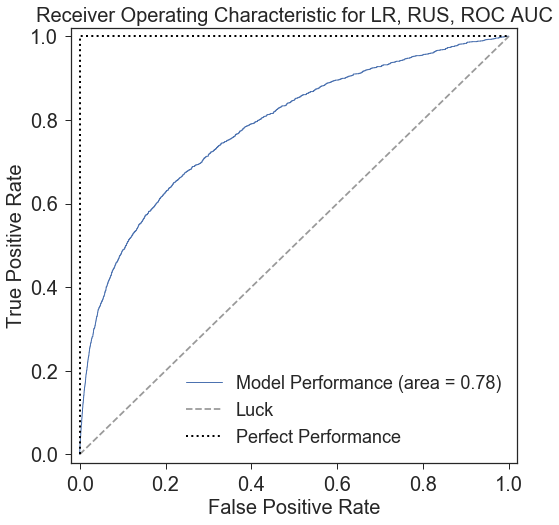

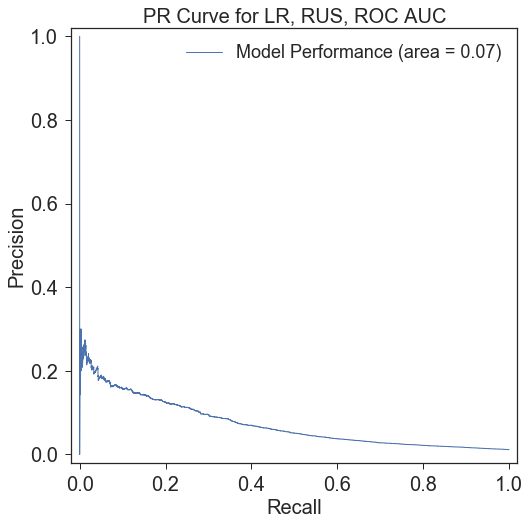

In [84]:
result(LRrusROC, X_train, y_train, X_test, y_test, train_result=False, clf_name="LR, RUS, ROC AUC")

The ROC curve looks much better when we optimize ROC AUC but the PR AUC is worst. When we optimize using PR AUC, we get better value for PR AUC on the test data. [Theoretically](http://ftp.cs.wisc.edu/machine-learning/shavlik-group/davis.icml06.pdf), ROC cruves are useful in an algorithm that optimizes PR AUC. So, we will stick with PR AUC as our scoring parameter. We have tried RUS  so far and got PR AUC = 0.51. We can try different sapmling techniques and also use class_weight parameter in RF classfier to see if any of these improve the PR AUC. 

## No under or over sampling, using class_weight

In [52]:
%%time
# Steps for pipeline
steps = [("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", LogisticRegression(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(model__C = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
                  model__penalty = ['l1', 'l2'],
                  model__class_weight = ['balanced']
                  )
# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
LRcw = GridSearchCV(pipe, param_grid = param_grid, 
                           verbose = 3,
                           cv = cv,
                          n_jobs=-1,
                          scoring='average_precision',
                          iid=False)
# Training using CV
LRcw.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] model__C=1e-08, model__class_weight=balanced, model__penalty=l1 .
[CV] model__C=1e-08, model__class_weight=balanced, model__penalty=l1 .
[CV] model__C=1e-08, model__class_weight=balanced, model__penalty=l1 .
[CV] model__C=1e-08, model__class_weight=balanced, model__penalty=l1 .
[CV] model__C=1e-08, model__class_weight=balanced, model__penalty=l1 .
[CV] model__C=1e-08, model__class_weight=balanced, model__penalty=l2 .
[CV] model__C=1e-08, model__class_weight=balanced, model__penalty=l2 .
[CV] model__C=1e-08, model__class_weight=balanced, model__penalty=l2 .
[CV]  model__C=1e-08, model__class_weight=balanced, model__penalty=l1, score=0.505740, total=   0.8s
[CV] model__C=1e-08, model__class_weight=balanced, model__penalty=l2 .
[CV]  model__C=1e-08, model__class_weight=balanced, model__penalty=l1, score=0.505740, total=   1.0s
[CV] model__C=1e-08, model__class_weight=balanced, model__penalty=l2 .
[CV]  model__C=1e-08, model

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s


[CV] model__C=1e-06, model__class_weight=balanced, model__penalty=l1 .
[CV]  model__C=1e-07, model__class_weight=balanced, model__penalty=l2, score=0.087704, total=   1.7s
[CV] model__C=1e-06, model__class_weight=balanced, model__penalty=l2 .
[CV]  model__C=1e-07, model__class_weight=balanced, model__penalty=l2, score=0.068661, total=   1.7s
[CV] model__C=1e-06, model__class_weight=balanced, model__penalty=l2 .
[CV]  model__C=1e-07, model__class_weight=balanced, model__penalty=l2, score=0.080378, total=   1.6s
[CV]  model__C=1e-06, model__class_weight=balanced, model__penalty=l1, score=0.505740, total=   1.5s
[CV] model__C=1e-06, model__class_weight=balanced, model__penalty=l2 .
[CV]  model__C=1e-06, model__class_weight=balanced, model__penalty=l1, score=0.505740, total=   1.5s
[CV] model__C=1e-06, model__class_weight=balanced, model__penalty=l2 .
[CV] model__C=1e-06, model__class_weight=balanced, model__penalty=l2 .
[CV]  model__C=1e-06, model__class_weight=balanced, model__penalty=l1

[CV]  model__C=0.01, model__class_weight=balanced, model__penalty=l1, score=0.053850, total= 1.3min
[CV]  model__C=0.001, model__class_weight=balanced, model__penalty=l1, score=0.035531, total= 3.5min
[CV]  model__C=0.01, model__class_weight=balanced, model__penalty=l1, score=0.054791, total= 3.3min
[CV]  model__C=0.001, model__class_weight=balanced, model__penalty=l1, score=0.038196, total= 3.6min


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  3.8min finished


CPU times: user 8.08 s, sys: 385 ms, total: 8.47 s
Wall time: 3min 50s


In [53]:
LRcw.best_params_

{'model__C': 1e-08, 'model__class_weight': 'balanced', 'model__penalty': 'l1'}

#####################
Test data
#####################
F1:  0.0
Cohen Kappa:  0.0
Brier:  0.011487011487
LogLoss:  0.69314718056
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    141216
          1       0.00      0.00      0.00      1641

avg / total       0.98      0.99      0.98    142857



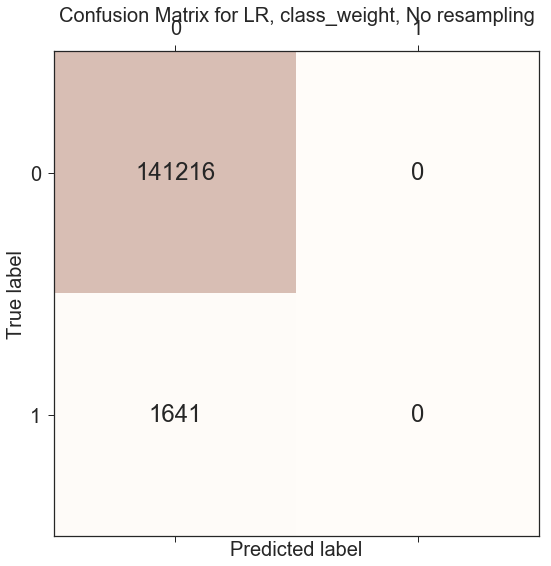

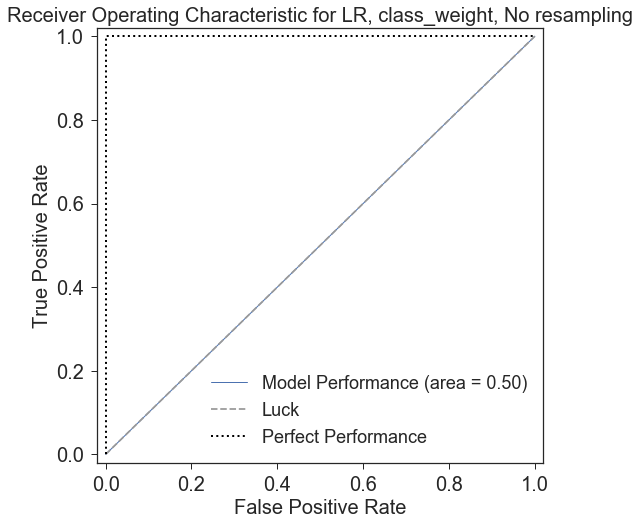

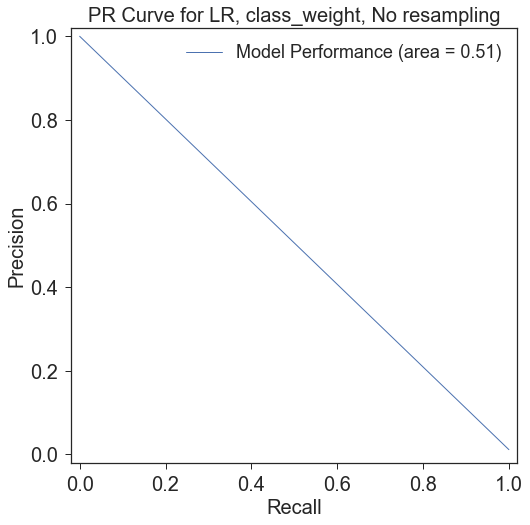

In [54]:
result(LRcw, X_train, y_train, X_test, y_test, train_result=False, clf_name="LR, class_weight, No resampling")

We get the same result as we got for RUS, no class_weight case. Lets now try to oversample the training data.

## SMOTE, PR AUC

In [90]:
%%time
from imblearn.over_sampling import SMOTE
# Steps for pipeline
steps = [("smote", SMOTE(random_state=30)),
        ("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", LogisticRegression(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(smote__kind = ['regular', 'borderline1', 'borderline2'],
                  model__C = [0.00001, 0.0001, 0.001],
                  model__penalty = ['l1', 'l2']
                  #model__class_weight = ['balanced']
                  )
# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
LRsmote = GridSearchCV(pipe, param_grid = param_grid, 
                           verbose = 4,
                           cv = cv,
                          n_jobs=-1,
                          scoring='average_precision',
                          iid=False)
# Training using CV
LRsmote.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] model__C=1e-05, model__penalty=l1, smote__kind=regular ..........
[CV] model__C=1e-05, model__penalty=l1, smote__kind=regular ..........
[CV] model__C=1e-05, model__penalty=l1, smote__kind=regular ..........
[CV] model__C=1e-05, model__penalty=l1, smote__kind=regular ..........
[CV] model__C=1e-05, model__penalty=l1, smote__kind=regular ..........
[CV] model__C=1e-05, model__penalty=l1, smote__kind=borderline1 ......
[CV] model__C=1e-05, model__penalty=l1, smote__kind=borderline1 ......
[CV] model__C=1e-05, model__penalty=l1, smote__kind=borderline1 ......
[CV]  model__C=1e-05, model__penalty=l1, smote__kind=regular, score=0.505740, total=   2.6s
[CV] model__C=1e-05, model__penalty=l1, smote__kind=borderline1 ......
[CV]  model__C=1e-05, model__penalty=l1, smote__kind=regular, score=0.505740, total=   2.7s
[CV] model__C=1e-05, model__penalty=l1, smote__kind=borderline1 ......
[CV]  model__C=1e-05, model__penalty=l1, smot

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.5s


[CV]  model__C=1e-05, model__penalty=l1, smote__kind=borderline2, score=0.505740, total=   6.3s
[CV] model__C=1e-05, model__penalty=l2, smote__kind=regular ..........
[CV]  model__C=1e-05, model__penalty=l1, smote__kind=borderline2, score=0.505740, total=   6.3s
[CV]  model__C=1e-05, model__penalty=l1, smote__kind=borderline2, score=0.505740, total=   6.2s
[CV] model__C=1e-05, model__penalty=l2, smote__kind=regular ..........
[CV] model__C=1e-05, model__penalty=l2, smote__kind=borderline1 ......
[CV]  model__C=1e-05, model__penalty=l2, smote__kind=regular, score=0.071891, total=   3.3s
[CV] model__C=1e-05, model__penalty=l2, smote__kind=borderline1 ......
[CV]  model__C=1e-05, model__penalty=l2, smote__kind=regular, score=0.045354, total=   3.9s
[CV]  model__C=1e-05, model__penalty=l1, smote__kind=borderline2, score=0.505740, total=   6.3s
[CV] model__C=1e-05, model__penalty=l2, smote__kind=borderline1 ......
[CV]  model__C=1e-05, model__penalty=l2, smote__kind=regular, score=0.083572,

[CV]  model__C=0.001, model__penalty=l1, smote__kind=regular, score=0.046799, total=  13.5s
[CV] model__C=0.001, model__penalty=l1, smote__kind=borderline1 ......
[CV] model__C=0.001, model__penalty=l1, smote__kind=borderline1 ......
[CV]  model__C=0.001, model__penalty=l1, smote__kind=borderline1, score=0.084152, total=  37.4s
[CV] model__C=0.001, model__penalty=l1, smote__kind=borderline1 ......
[CV]  model__C=0.001, model__penalty=l1, smote__kind=borderline1, score=0.052189, total=  34.5s
[CV] model__C=0.001, model__penalty=l1, smote__kind=borderline2 ......
[CV]  model__C=0.001, model__penalty=l1, smote__kind=regular, score=0.071525, total= 1.5min
[CV] model__C=0.001, model__penalty=l1, smote__kind=borderline2 ......
[CV]  model__C=0.001, model__penalty=l1, smote__kind=borderline1, score=0.079743, total= 1.9min
[CV] model__C=0.001, model__penalty=l1, smote__kind=borderline2 ......
[CV]  model__C=0.001, model__penalty=l1, smote__kind=borderline2, score=0.087176, total= 1.4min
[CV] m

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.7min finished


CPU times: user 11.1 s, sys: 629 ms, total: 11.7 s
Wall time: 4min 45s


In [91]:
LRsmote.best_params_

{'model__C': 1e-05, 'model__penalty': 'l1', 'smote__kind': 'regular'}

#####################
Test data
#####################
F1:  0.0
Cohen Kappa:  0.0
Brier:  0.011487011487
LogLoss:  0.69314718056
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    141216
          1       0.00      0.00      0.00      1641

avg / total       0.98      0.99      0.98    142857



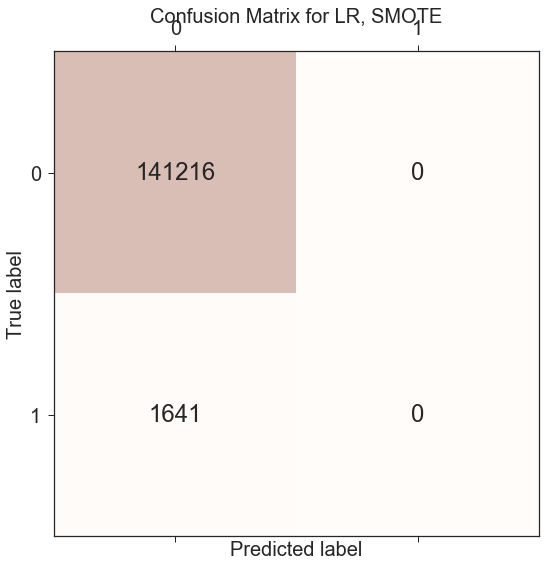

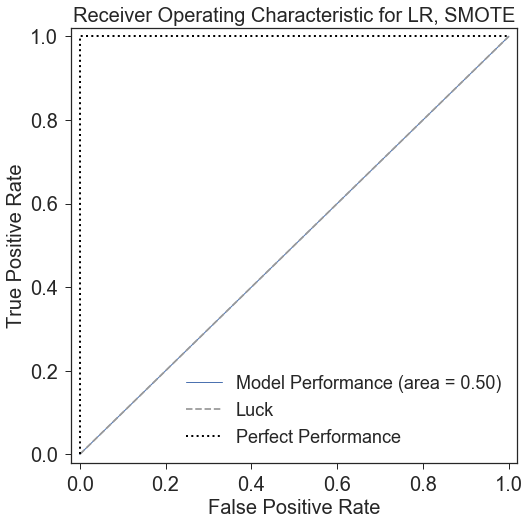

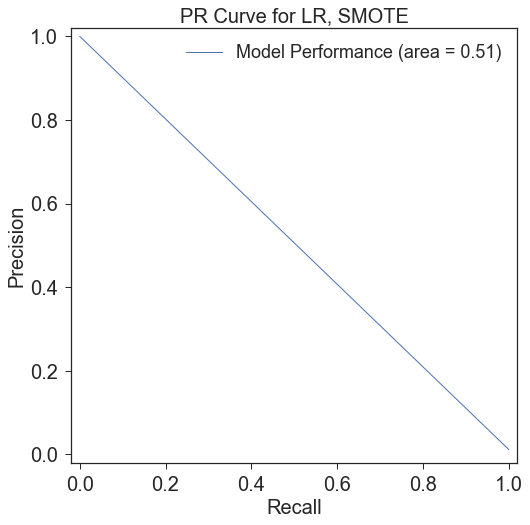

In [92]:
result(LRsmote, X_train, y_train, X_test, y_test, train_result=False, clf_name="LR, SMOTE")

SMOTEing gives the same result as RUSing. SMOTE is much expensive to compute than RUS. So, we igonre SMOTE from now on. We can pick either RUS or class_weight without any resampling. Overall, what we are getting using logisitic regression is really bad, especially if we look at ROC curve. Is there anything else that we can do to improve ROC curve, even if the PR AUC goes down a little bit? To experiment few options, lets pick the case with class_weight (and no reampling) and try different things.

## Experiment 1:

Remove correlated features

In [93]:
corrs = df.corr().abs().stack()

In [94]:
corrs[(corrs > 0.9) & (corrs != 1.0)].sort_values(ascending=True)

TempFlight_10     TempFlight_20       0.901873
TempFlight_20     TempFlight_10       0.901873
TaxiOutMedian_10  TaxiOutMedian_20    0.906585
TaxiOutMedian_20  TaxiOutMedian_10    0.906585
AllCanceled_20    AllCanceled_30      0.906624
AllCanceled_30    AllCanceled_20      0.906624
TaxiInMedian_10   TaxiInMedian_20     0.915917
TaxiInMedian_20   TaxiInMedian_10     0.915917
TempFlight_30     TempFlight_20       0.935875
TempFlight_20     TempFlight_30       0.935875
Nflights_10       Nflights_30         0.949165
Nflights_30       Nflights_10         0.949165
TaxiOutMedian_30  TaxiOutMedian_20    0.954341
TaxiOutMedian_20  TaxiOutMedian_30    0.954341
TaxiInMedian_30   TaxiInMedian_20     0.958748
TaxiInMedian_20   TaxiInMedian_30     0.958748
DayOfWeek         DayOfWeek_Dest      0.960615
DayOfWeek_Dest    DayOfWeek           0.960615
ArrDelayMax_10    DepDelayMax_10      0.973427
DepDelayMax_10    ArrDelayMax_10      0.973427
Nflights_10       Nflights_20         0.976134
Nflights_20  

We observe that calander variables "Month", "DayofMonth" and "DayofWeek" for origin and destination airports are highly correlated. So, we can remove these variables for destination airport. Also, there are some historical performance varibles that are highly correlated such as "Nflights_10", "Nflights_20", "ArrDelayMax_30", "ArrDelayMax_20", "ArrDelayMax_10", "TaxiInMedian_20", "TaxiOutMedian_20". Lets remove these features and see if that improves our model.

In [95]:
df1 = df.drop(["Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest", "Nflights_10", "Nflights_20", 
         "ArrDelayMax_30", "ArrDelayMax_20", "ArrDelayMax_10", "TaxiInMedian_20", "TaxiOutMedian_20"], 
        axis=1, inplace=False)
X1 = df1.drop(["Cancelled"], axis=1).values
y1 = df1.Cancelled.astype(int).values

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=10)
for keep_index1, leave_index1 in sss1.split(X1, y1):
    X_keep1, X_leave1 = X1[keep_index1], X1[leave_index1]
    y_keep1, y_leave1 = y1[keep_index1], y1[leave_index1]
    
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=20)
for train_index1, test_index1 in sss2.split(X_keep1, y_keep1):
    X_train1, X_test1 = X_keep1[train_index1], X_keep1[test_index1]
    y_train1, y_test1 = y_keep1[train_index1], y_keep1[test_index1]

In [102]:
steps = [("rus", RandomUnderSampler(random_state=30)),
         ("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", LogisticRegression(random_state=40, C = 1e-8, penalty = 'l1'))]
LRexp1 = pl(steps)
# Training using CV
LRexp1.fit(X_train1, y_train1)

Pipeline(steps=[('rus', RandomUnderSampler(random_state=30, ratio='auto', replacement=True,
          return_indices=False)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 10))), ('model', LogisticRegression(C=1e-08, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=40, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

#####################
Test data
#####################
F1:  0.0
Cohen Kappa:  0.0
Brier:  0.011487011487
LogLoss:  0.69314718056
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    141216
          1       0.00      0.00      0.00      1641

avg / total       0.98      0.99      0.98    142857



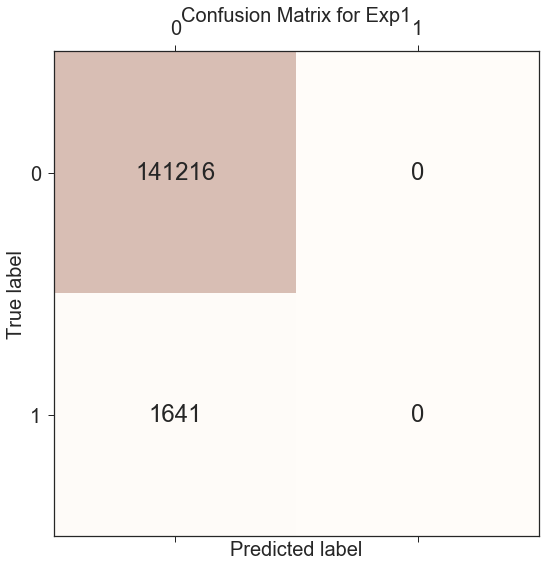

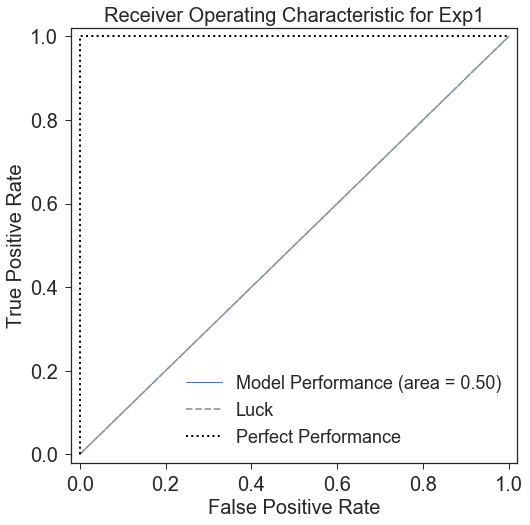

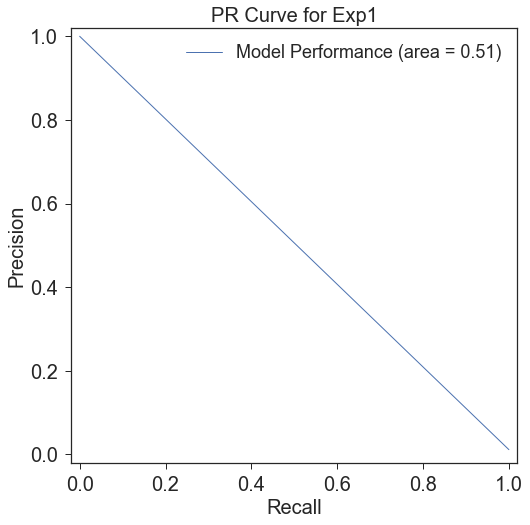

In [103]:
result(LRexp1, X_train1, y_train1, X_test1, y_test1, train_result=False, clf_name="Exp1")

Remving features also does not help in improving the ROC curve. It is clear so far that if we want to maximize PR AUC, the logistic regression algorithm produces predictions that are absolutely by "chance" or "luck" by penalizing the coefficients very strongly (very high regularization). This also means that we get high bias model, i.e. underfit model, which explains the term "luck". 

In any case, for completeness, we will run the model again with the whole data.

In [104]:
del df
del df1
del X
del y
del X_train
del X_test
del y_train
del y_test
del X1
del y1
del X_keep
del X_keep1
del X_leave
del X_leave1
del X_train1
del X_test1
del y_keep1
del y_keep
del y_test1
del y_train1
del corrs
del tmp

## Final Iteration

In [105]:
df = pd.read_csv("../Data/ExploredDataCleaned/FlightHistory_Weather_Jan2015-Dec2016_Top20Airports_Window60mins_ExploredCleaned.csv")

In [106]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [107]:
catvar = ["Month", "DayofMonth", "DayOfWeek", "Carrier", "Origin", "Dest", "CRSDepHr", "CRSArrHr", 
          "Condition_Origin", "Condition_Dest", "Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest"]
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()
tmp = df[catvar].apply(lbl_enc.fit_transform)
df.drop(catvar, axis=1, inplace=True)
df = pd.concat([df, tmp], axis=1)

In [108]:
X = df.drop(["Cancelled"], axis=1).values
y = df.Cancelled.astype(int).values

In [109]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=10)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#####################
Test data
#####################
F1:  0.0
Cohen Kappa:  0.0
Brier:  0.011487011487
LogLoss:  0.69314718056
             precision    recall  f1-score   support

          0       0.99      1.00      0.99   1412160
          1       0.00      0.00      0.00     16410

avg / total       0.98      0.99      0.98   1428570

CPU times: user 5.46 s, sys: 1.14 s, total: 6.6 s
Wall time: 5.42 s


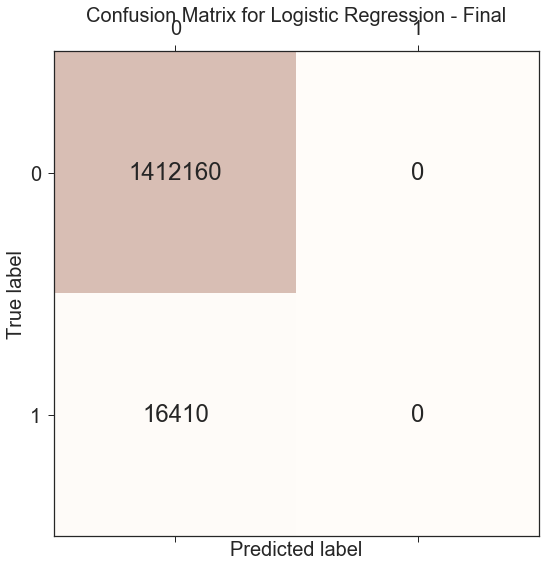

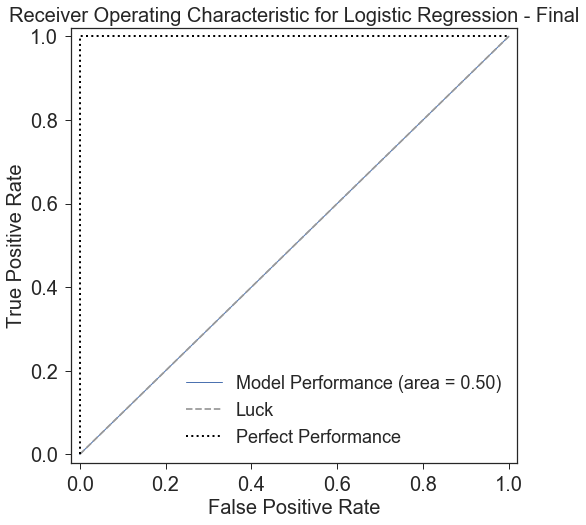

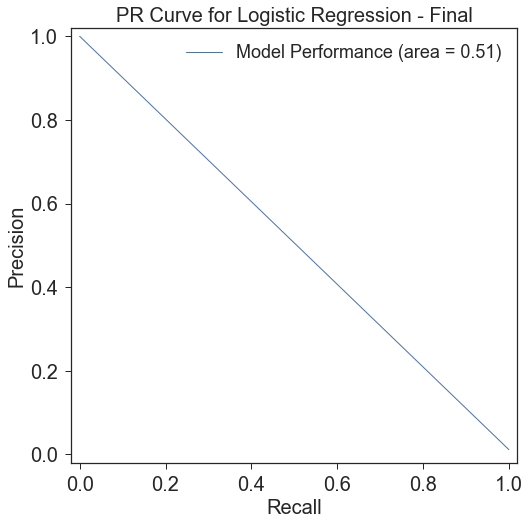

In [110]:
%%time
steps = [("rus", RandomUnderSampler(random_state=30)),
         ("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", LogisticRegression(random_state=40, C = 1e-8, penalty = 'l1'))]
LR_final = pl(steps)
LR_final.fit(X_train, y_train)
result(LR_final, X_train, y_train, X_test, y_test, train_result=False, clf_name="Logistic Regression - Final")

We can pickle the final model now.

In [111]:
import dill
dill.dump(LR_final, open('LogisticRegression.pkl', 'wb'))

## Function to calculate various evaluation metrics and plot ROC and PR curves

In [35]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, cohen_kappa_score
def result(model, X_train, y_train, X_test, y_test, train_result, clf_name):
    """ This function calculates different metrics to show the model's performance on both training and test data.
    This functoin also shows the confusion matrix, and plots the ROC and PR curves.
    
    Parameters
    ----------
    model (dtype: sklearn.model_selection._search.GridSearchCV) : The classifier model
    train_result (dtype: boolean): If YES, calculate results for train data
    clf_name (dtype: str): Name of the classifier
    """
    if train_result:
        y_pred_train = model.predict(X_train) # class prediction
        y_pred_train_prob = model.predict_proba(X_train) # probability of each class prediction
        print("#####################")
        print("Train data")
        print("#####################")
        print("F1: ", metrics.f1_score(y_train, y_pred_train))
        print("Cohen Kappa: ", metrics.cohen_kappa_score(y_train, y_pred_train))
        print("Brier: ", metrics.brier_score_loss(y_train, y_pred_train))
        print("LogLoss: ", metrics.log_loss(y_train, y_pred_train_prob))
        print(metrics.classification_report(y_train, y_pred_train))
        print(metrics.confusion_matrix(y_train, y_pred_train))
    else:
        pass
    
    y_pred_test = model.predict(X_test)
    y_pred_test_prob = model.predict_proba(X_test)
    print("#####################")
    print("Test data")
    print("#####################")
    print("F1: ", metrics.f1_score(y_test, y_pred_test))
    print("Cohen Kappa: ", metrics.cohen_kappa_score(y_test, y_pred_test))
    print("Brier: ", metrics.brier_score_loss(y_test, y_pred_test))
    print("LogLoss: ", metrics.log_loss(y_test, y_pred_test_prob))
    print(metrics.classification_report(y_test, y_pred_test))
    conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)
    
    # Displaying the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', fontsize=24)

    plt.title('Confusion Matrix for %s' % clf_name, size=20)
    plt.xlabel('Predicted label', size=20)
    plt.ylabel('True label', size=20)
    ax.tick_params('x', labelsize = 20)
    ax.tick_params('y', labelsize = 20)
    plt.tight_layout()
    
    # ROC curve
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='Model Performance (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], 
             [0, 1], 
             '--', 
             color=(0.6, 0.6, 0.6), 
             label='Luck')
    
    plt.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2,
             linestyle=':',
             color='black',
             label='Perfect Performance')
        
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', size=20)
    plt.ylabel('True Positive Rate', size=20)
    plt.title('Receiver Operating Characteristic for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="lower right", fontsize=18)
    
    # PR curve
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    prec, recall, thresholds = precision_recall_curve(y_test, y_pred_test_prob[:, 1])
    #pr_auc = auc(prec, recall)
    plt.plot(recall, prec, lw=1, label='Model Performance (area = %0.2f)' % 
             (metrics.average_precision_score(y_test, y_pred_test_prob[:, 1])))    
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('Recall', size=20)
    plt.ylabel('Precision', size=20)
    plt.title('PR Curve for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="top right", fontsize=18)